What online risks do teens actually face, and have they changed over time?

This analysis uses the Teen E-Safety Dataset (67,921 sessions, 2017-2024) to establish baseline
risk exposure patterns before analyzing whether state legislation addresses these actual risks.

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

sns.set_style("whitegrid")
sns.set_palette("colorblind")  # Accessibility
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11


print("✓ Libraries loaded")

✓ Libraries loaded


In [5]:
print("\n=== LOADING DATA ===")
df = pl.read_csv("../data/teen_e_safety_dataset.csv")

print(f"Total sessions: {len(df):,}")
print(f"Time period: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print(f"Columns: {len(df.columns)}")

print("\n=== DATASET STRUCTURE ===")
print(f"Age groups: {df['Age_Group'].unique().to_list()}")
print(f"Locations: {df['Geolocation'].unique().to_list()}")

# Show sample
print("\nSample records:")
print(df.head(3))


=== LOADING DATA ===
Total sessions: 67,921
Time period: 2017-01-01 00:00:00 to 2024-10-01 00:00:00
Columns: 30

=== DATASET STRUCTURE ===
Age groups: ['17-19', '<13', '13-16']
Locations: ['ASIA', 'US', 'OTHER', 'EU']

Sample records:
shape: (3, 30)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Timestamp ┆ Device_Ty ┆ Malware_D ┆ Phishing_ ┆ … ┆ Insecure_ ┆ E_Safety_ ┆ Malware_E ┆ Cybersec │
│ ---       ┆ pe        ┆ etection  ┆ Attempts  ┆   ┆ Login_Att ┆ Awareness ┆ xposure_R ┆ urity_Be │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ empts     ┆ _Score    ┆ isk       ┆ havior_C │
│           ┆ str       ┆ i64       ┆ i64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ategor…  │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆ str       ┆ i64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═════

In [7]:
df_us = df.filter(pl.col('Geolocation') == 'US')
print(f"\n✓ Filtered to US sessions: {len(df_us):,} records ({len(df_us)/len(df)*100:.1f}% of total)")

df_us = df_us.with_columns([
    pl.col('Timestamp').str.slice(0, 4).cast(pl.Int32).alias('Year')
])

year_counts = df_us.group_by('Year').agg(pl.len().alias('sessions')).sort('Year')
print(year_counts)


✓ Filtered to US sessions: 40,807 records (60.1% of total)
shape: (8, 2)
┌──────┬──────────┐
│ Year ┆ sessions │
│ ---  ┆ ---      │
│ i32  ┆ u32      │
╞══════╪══════════╡
│ 2017 ┆ 5191     │
│ 2018 ┆ 5364     │
│ 2019 ┆ 5256     │
│ 2020 ┆ 5302     │
│ 2021 ┆ 5240     │
│ 2022 ┆ 5212     │
│ 2023 ┆ 5263     │
│ 2024 ┆ 3979     │
└──────┴──────────┘


In [8]:
risk_metrics = {
    'Malware_Detection': 'Malware Exposure',
    'Phishing_Attempts': 'Phishing (>0 attempts)',
    'Risky_Website_Visits': 'Risky Site Visits', 
    'Cyberbullying_Reports': 'Cyberbullying (>0 reports)'
}

print("OVERALL RISK EXPOSURE (All US Sessions):")
total_us = len(df_us)

for col, label in risk_metrics.items():
    if 'Attempts' in col or 'Reports' in col:
        # Count sessions with any incidents
        count = len(df_us.filter(pl.col(col) > 0))
    else:
        # Binary flags
        count = df_us[col].sum()
    
    rate = count / total_us * 100
    print(f"  {label:30} {count:6,} sessions ({rate:5.1f}%)")


OVERALL RISK EXPOSURE (All US Sessions):
  Malware Exposure                1,982 sessions (  4.9%)
  Phishing (>0 attempts)         10,452 sessions ( 25.6%)
  Risky Site Visits               4,048 sessions (  9.9%)
  Cyberbullying (>0 reports)        772 sessions (  1.9%)


In [9]:
print("\n\nTEEN PROTECTIVE BEHAVIORS:")

# VPN Usage
vpn_rate = len(df_us.filter(pl.col('VPN_Usage') == 1)) / total_us * 100
print(f"  VPN Usage:                     {vpn_rate:5.1f}%")

# Strong passwords
strong_pw = len(df_us.filter(pl.col('Password_Strength') == 'Strong')) / total_us * 100
print(f"  Strong Passwords:              {strong_pw:5.1f}%")



TEEN PROTECTIVE BEHAVIORS:
  VPN Usage:                      14.8%
  Strong Passwords:                5.2%


In [17]:
print("\n\n=== RISK TRENDS OVER TIME (2017-2024) ===\n")

# Calculate risk rates by year
yearly_data = {}

for year in sorted(df_us['Year'].unique().to_list()):
    year_data = df_us.filter(pl.col('Year') == year)
    n = len(year_data)
    
    yearly_data[year] = {'Sessions': n}
    
    print(f"{year} (n={n:,}):")
    
    for col, label in risk_metrics.items():
        if 'Attempts' in col or 'Reports' in col:
            count = len(year_data.filter(pl.col(col) > 0))
        else:
            count = year_data[col].sum()
        
        rate = count / n * 100 if n > 0 else 0
        yearly_data[year][label] = rate
        print(f"  {label:30} {rate:5.1f}%")
    print()

# Prepare data for plotting
years = sorted(yearly_data.keys())
sessions = [yearly_data[y]['Sessions'] for y in years]

# Extract each risk metric as a list
risk_data = {}
for risk in risk_metrics.values():
    risk_data[risk] = [yearly_data[y][risk] for y in years]



=== RISK TRENDS OVER TIME (2017-2024) ===

2017 (n=5,191):
  Malware Exposure                 4.4%
  Phishing (>0 attempts)          25.7%
  Risky Site Visits                9.9%
  Cyberbullying (>0 reports)       1.8%

2018 (n=5,364):
  Malware Exposure                 4.6%
  Phishing (>0 attempts)          25.4%
  Risky Site Visits               10.0%
  Cyberbullying (>0 reports)       2.0%

2019 (n=5,256):
  Malware Exposure                 5.0%
  Phishing (>0 attempts)          25.5%
  Risky Site Visits               10.2%
  Cyberbullying (>0 reports)       1.6%

2020 (n=5,302):
  Malware Exposure                 5.2%
  Phishing (>0 attempts)          25.4%
  Risky Site Visits                9.7%
  Cyberbullying (>0 reports)       1.6%

2021 (n=5,240):
  Malware Exposure                 4.7%
  Phishing (>0 attempts)          26.2%
  Risky Site Visits                9.2%
  Cyberbullying (>0 reports)       2.1%

2022 (n=5,212):
  Malware Exposure                 4.9%
  Phishing (>0

✓ Saved: output/figures/teen_risk_longitudinal.png


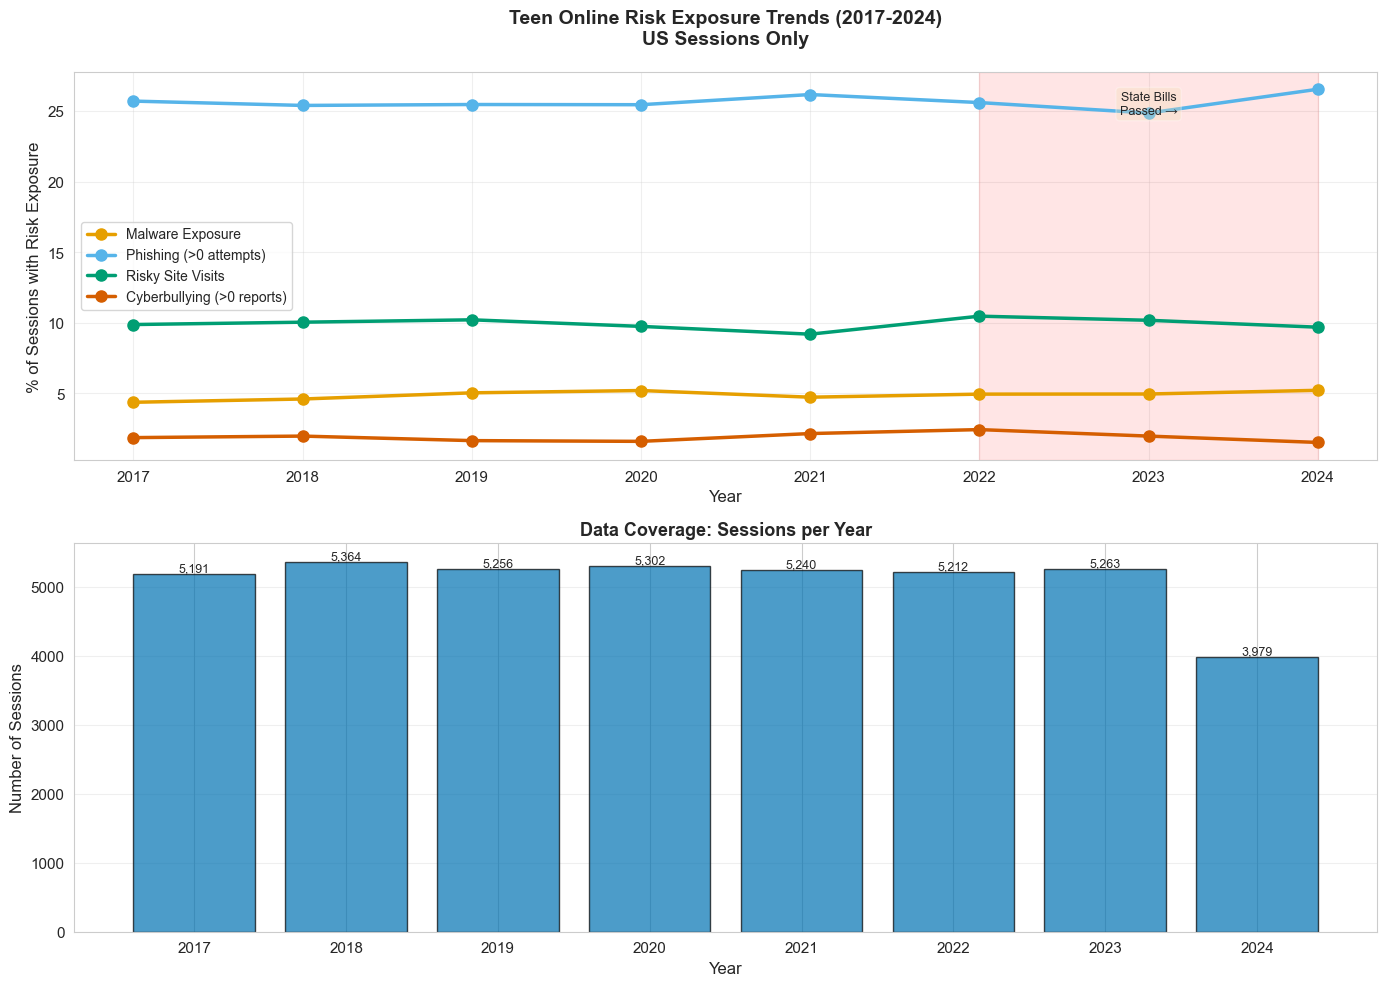

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: All risks over time
colors_map = {
    'Malware Exposure': '#E69F00',
    'Phishing (>0 attempts)': '#56B4E9', 
    'Risky Site Visits': '#009E73',
    'Cyberbullying (>0 reports)': '#D55E00'
}

for risk, values in risk_data.items():
    ax1.plot(years, values, 
             marker='o', linewidth=2.5, markersize=8,
             label=risk, color=colors_map.get(risk, '#000000'))

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('% of Sessions with Risk Exposure', fontsize=12)
ax1.set_title('Teen Online Risk Exposure Trends (2017-2024)\nUS Sessions Only', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(years)

# Add annotation for legislative activity period
if max(years) >= 2022:
    ax1.axvspan(2022, max(years), alpha=0.1, color='red')
    mid_year = (2022 + max(years)) / 2
    ax1.text(mid_year, ax1.get_ylim()[1] * 0.95, 
             'State Bills\nPassed →', 
             ha='center', va='top', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Plot 2: Session volume over time
ax2.bar(years, sessions, 
        color='#0072B2', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Number of Sessions', fontsize=12)
ax2.set_title('Data Coverage: Sessions per Year', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticks(years)

# Add value labels
for year, count in zip(years, sessions):
    ax2.text(year, count, 
             f"{int(count):,}", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../output/figures/teen_risk_longitudinal.png', dpi=300, bbox_inches='tight')
print("✓ Saved: output/figures/teen_risk_longitudinal.png")
plt.show()


In [21]:
age_analysis = []

for age in ['<13', '13-16', '17-19']:
    age_data = df_us.filter(pl.col('Age_Group') == age)
    n = len(age_data)
    
    print(f"{age} (n={n:,}):")
    
    for col, label in risk_metrics.items():
        if 'Attempts' in col or 'Reports' in col:
            count = len(age_data.filter(pl.col(col) > 0))
        else:
            count = age_data[col].sum()
        
        rate = count / n * 100
        print(f"  {label:30} {rate:5.1f}%")
    print()


<13 (n=4,074):
  Malware Exposure                 4.3%
  Phishing (>0 attempts)          24.6%
  Risky Site Visits                9.7%
  Cyberbullying (>0 reports)       2.1%

13-16 (n=28,620):
  Malware Exposure                 4.8%
  Phishing (>0 attempts)          25.6%
  Risky Site Visits               10.0%
  Cyberbullying (>0 reports)       1.8%

17-19 (n=8,113):
  Malware Exposure                 5.2%
  Phishing (>0 attempts)          26.2%
  Risky Site Visits                9.8%
  Cyberbullying (>0 reports)       2.0%

